In [31]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from PIL import Image
from keras.preprocessing import image
from keras.layers import Dense,Input,Activation,Dropout,Flatten,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
import os


In [19]:
dirs = os.listdir('./data')

In [20]:
print(dirs)
label_dirs = {'dogs':0,'cats':1,'horses':2,'Humans':3}

['Humans', 'horses', 'cats', 'dogs']


In [49]:
data_path = 'data/'
image_data=[]
labels=[]

In [50]:
for fold in dirs:
    path = data_path+fold+'/'
    images = os.listdir(path)
    for im in images:
        im_path = path+im
        img = image.load_img(im_path,target_size=(224,224))
        
        labels.append(label_dirs[fold])  
        img_array = image.img_to_array(img)
        image_data.append(img_array)
      
        

In [38]:
# image_data = np.array(image_data)
# labels=np.array(labels)

In [39]:
# print(image_data.shape)
# print(labels.shape)

In [51]:
combined = list(zip(image_data,labels))
random.shuffle(combined)
image_data[:],labels[:] = zip(*combined)

In [54]:
x_train = np.array(image_data)
y_train = np.array(labels)
y_train = np_utils.to_categorical(y_train)

print(x_train.shape)
print(y_train.shape)

(808, 224, 224, 3)
(808, 4)


## using Transfer Learning with Resnet Architecture trained on ImageNet Dataset

In [42]:
model = ResNet50(include_top = False,weights = 'imagenet',input_shape=(224,224,3))

In [43]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [44]:
avg = GlobalAveragePooling2D()(model.output)
fc1=Dense(256,activation='relu')(avg)
drp = Dropout(0.25)(fc1)
fc2 = Dense(4,activation='softmax')(drp)

model_new = Model(inputs=model.input,outputs=fc2)
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [57]:
adam = Adam(lr=0.00003)
model_new.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [60]:
for ix in range(len(model_new.layers)):
    print ix, model_new.layers[ix]

0 <keras.engine.input_layer.InputLayer object at 0x7f21d1dc2b10>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7f21d1dc2c90>
2 <keras.layers.convolutional.Conv2D object at 0x7f21d1dc2410>
3 <keras.layers.normalization.BatchNormalization object at 0x7f21d1dc2d50>
4 <keras.layers.core.Activation object at 0x7f21d1dc2e50>
5 <keras.layers.convolutional.ZeroPadding2D object at 0x7f21ef58d4d0>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f21d1e91bd0>
7 <keras.layers.convolutional.Conv2D object at 0x7f2229619f90>
8 <keras.layers.normalization.BatchNormalization object at 0x7f21d1cd29d0>
9 <keras.layers.core.Activation object at 0x7f21d1cd2dd0>
10 <keras.layers.convolutional.Conv2D object at 0x7f21d1cfc2d0>
11 <keras.layers.normalization.BatchNormalization object at 0x7f21d1c318d0>
12 <keras.layers.core.Activation object at 0x7f21d1c49790>
13 <keras.layers.convolutional.Conv2D object at 0x7f218f3725d0>
14 <keras.layers.convolutional.Conv2D object at 0x7f218f3b5c90>
15 <keras.lay

#last Conv layer is indexed 171 , so we will make 171 layers as non-trainable and wont update the weights for our network untill 171

In [61]:
for ix in range(171):
    model_new.layers[ix].trainable = False
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

#around 23 million parameters are sustained as of imagenet

In [63]:
hist = model_new.fit(x_train,y_train,epochs=5,shuffle=True,batch_size=16,validation_split=0.2)


Train on 646 samples, validate on 162 samples
Epoch 1/5
646/646 [==============================] - 194s 301ms/step - loss: 0.4707 - acc: 0.8669 - val_loss: 0.3487 - val_acc: 0.8765
Epoch 2/5
646/646 [==============================] - 201s 311ms/step - loss: 0.2705 - acc: 0.9396 - val_loss: 0.2277 - val_acc: 0.9198
Epoch 3/5
646/646 [==============================] - 203s 314ms/step - loss: 0.1993 - acc: 0.9613 - val_loss: 0.2041 - val_acc: 0.9259
Epoch 4/5
646/646 [==============================] - 205s 317ms/step - loss: 0.1637 - acc: 0.9567 - val_loss: 0.1829 - val_acc: 0.9259
Epoch 5/5
646/646 [==============================] - 200s 310ms/step - loss: 0.1175 - acc: 0.9752 - val_loss: 0.1505 - val_acc: 0.9321


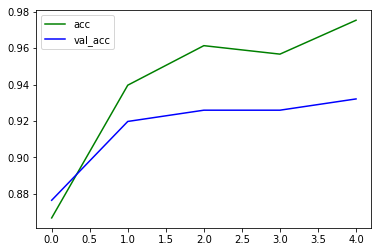

In [64]:
plt.figure(0)
plt.plot(hist.history['acc'],'g',label='acc')
plt.plot(hist.history['val_acc'],'b',label='val_acc')
plt.legend()
plt.show()

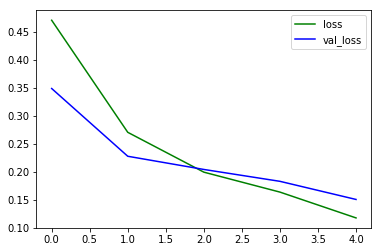

In [65]:
plt.figure(0)
plt.plot(hist.history['loss'],'g',label='loss')
plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.legend()
plt.show()